In [1]:
import plotly.express as px
from tinyshift.series import trend_significance
from utilsforecast.preprocessing import fill_gaps
from tinyshift.plot import corr_heatmap
import plotly.express as px
from utils import remove_leading_zeros, is_obsolete, forecastability, generate_lag
from tinyshift.series import fourier_seasonality
from tinyshift.plot import stationarity_check, seasonal_decompose
import pandas as pd
from statsforecast import StatsForecast
from utilsforecast.losses import rmse, mae, bias, cfe
from utilsforecast.evaluation import evaluate
from statsforecast.models import AutoARIMA, Naive, AutoETS, AutoTheta, AutoCES
import numpy as np

/home/heylucasleao/forecasting/.venv/lib/python3.10/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/home/heylucasleao/forecasting/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'])
df["unique_id"] = "1"
df.rename(columns={"Month": "ds", "Passengers": "y"}, inplace=True)

In [3]:
df.isnull().sum()

ds           0
y            0
unique_id    0
dtype: int64

In [4]:
df

,ds,y,unique_id
0,1949-01-01,112,1
1,1949-02-01,118,1
2,1949-03-01,132,1
3,1949-04-01,129,1
4,1949-05-01,121,1
...,...,...,...
139,1960-08-01,606,1
140,1960-09-01,508,1
141,1960-10-01,461,1
142,1960-11-01,390,1


In [5]:
df = fill_gaps(df, freq="ME", end="per_serie", id_col="unique_id", time_col="ds")

In [6]:
df = df.groupby("unique_id")[df.columns].apply(remove_leading_zeros).reset_index(drop=True)

In [7]:
days_obsoletes=180
obsolete_series = df.groupby("unique_id")[df.columns].apply(is_obsolete, days_obsoletes)

In [8]:
obsolote_ids = obsolete_series[obsolete_series].index.tolist()

In [9]:
obsolote_ids

[]

In [10]:
df.groupby("unique_id")["y"].apply(trend_significance)

unique_id
1    (0.853638165603188, 4.020274506593391e-61)
Name: y, dtype: object

In [11]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [12]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [13]:
df.groupby("unique_id")["y"].apply(forecastability)

unique_id                   
1          foreCA                                               0.571263
           theoretical_limit                                    0.086973
           stability_index                                      0.183962
           adi_cv                             (1.0, 0.18190737443351804)
           hurst_exponent       (0.5203628364992473, 0.8044229708616066)
Name: y, dtype: object

# ADF Test - Order of Diff 1

In [14]:
df["lag_1"] = generate_lag(df["y"], lag=1)
df["lag_12"] = generate_lag(df["lag_1"], lag=12)
#df = df.dropna()

In [15]:
df

,unique_id,ds,y,lag_1,lag_12
0,1,1949-01-01,112,NaN,NaN
1,1,1949-02-01,118,6.0,NaN
2,1,1949-03-01,132,14.0,NaN
3,1,1949-04-01,129,-3.0,NaN
4,1,1949-05-01,121,-8.0,NaN
...,...,...,...,...,...
139,1,1960-08-01,606,-16.0,-27.0
140,1,1960-09-01,508,-98.0,-2.0
141,1,1960-10-01,461,-47.0,9.0
142,1,1960-11-01,390,-71.0,-26.0


In [16]:
#df.groupby("unique_id")["lag_1"].apply(adfuller)

# Domingo

- #TODO: Adicionar gráfico de STL
- #TODO: Interpretar
- #TODO: Adicionar gráficos da aula do valeriy
- #TODO: Comparativo de dados diferenciados
- #TODO: Trazer gráficos de ipynbs dele

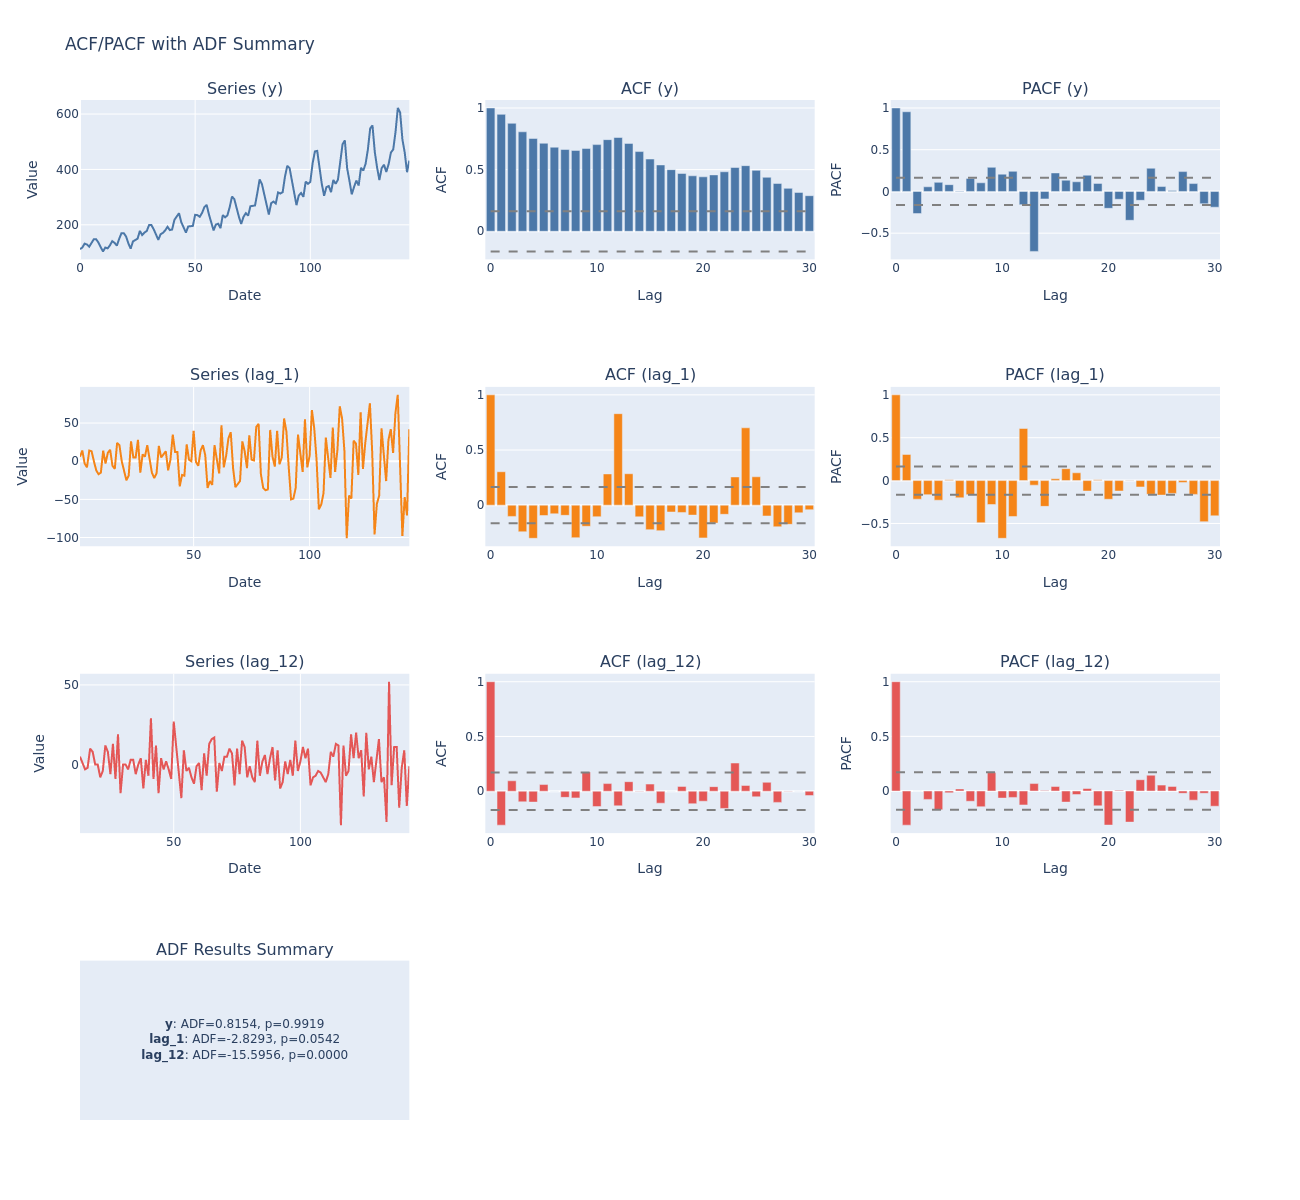

In [17]:
stationarity_check(df[["y", "lag_1", "lag_12"]], fig_type="png")

In [18]:
df[["y", "lag_1", "lag_12"]].shape[1]

3

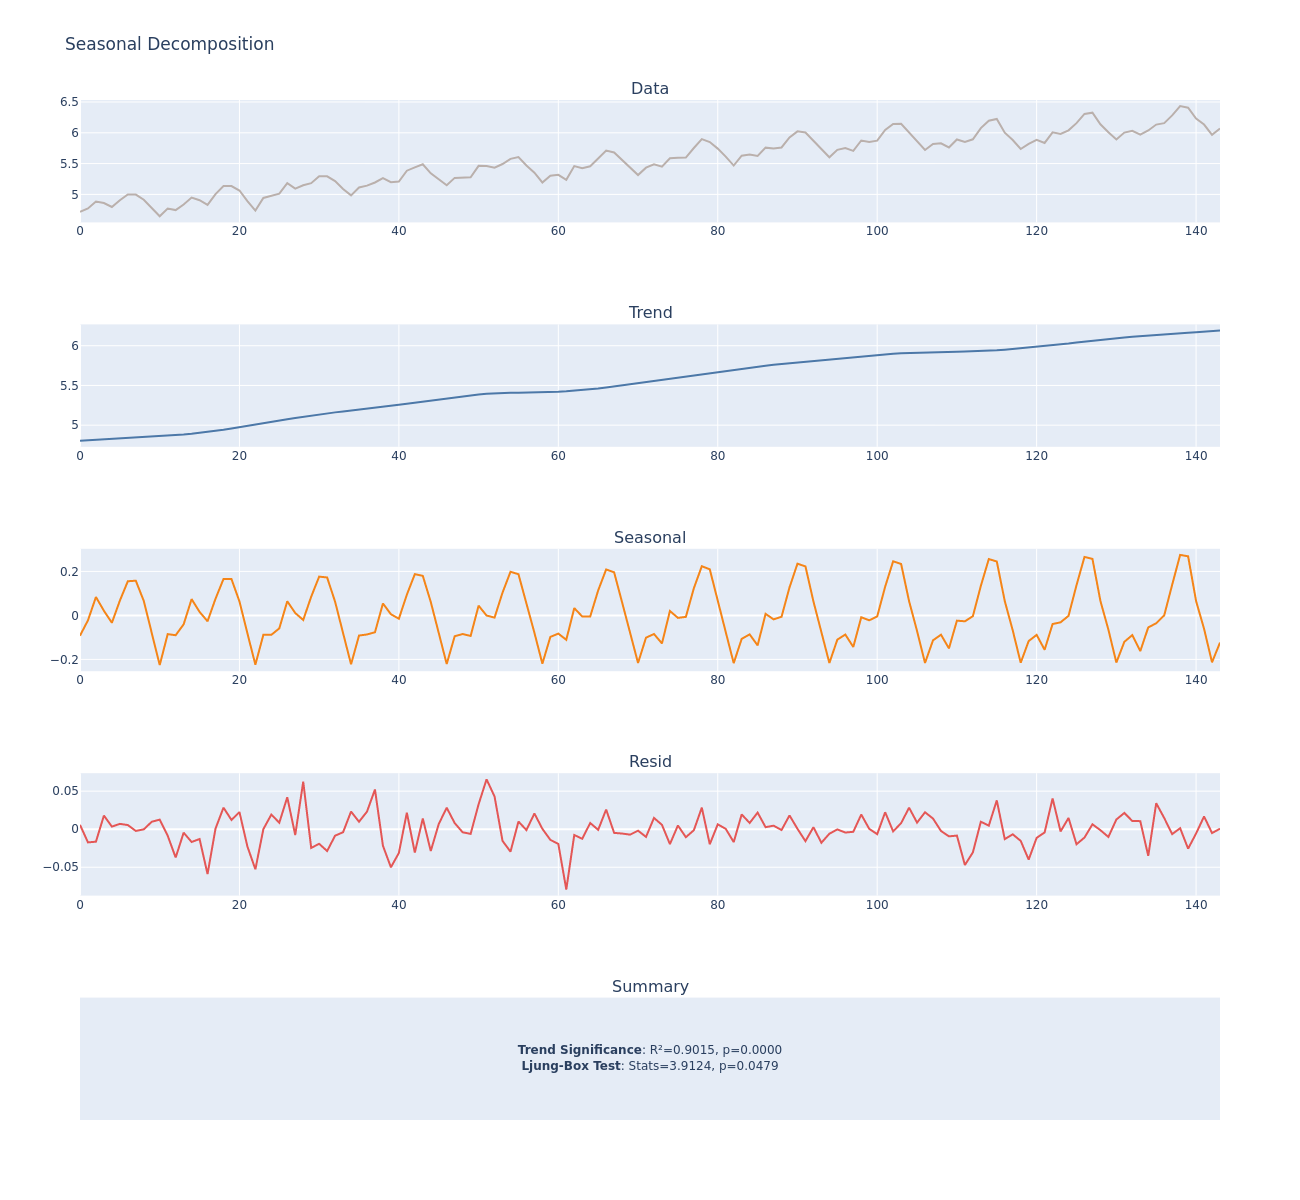

In [30]:
seasonal_decompose(np.log(df["y"]), periods=12, fig_type="png", ljung_lags=1)

## Features
- ~~STL~~
- ~~Holidays~~
- ~~Série de fourier para padrões cíclicos (seno e cosseno) - dia da semana, dia do ano~~
- ~~mês~~
- ~~fim do mês~~
- ~~Lags~~
- Rolling Windows: médias, desvio padrão e permutação da entropia

In [ ]:
df = fourier_seasonality(df, "ds", seasonality=["monthly"])

In [ ]:
df = df.dropna()

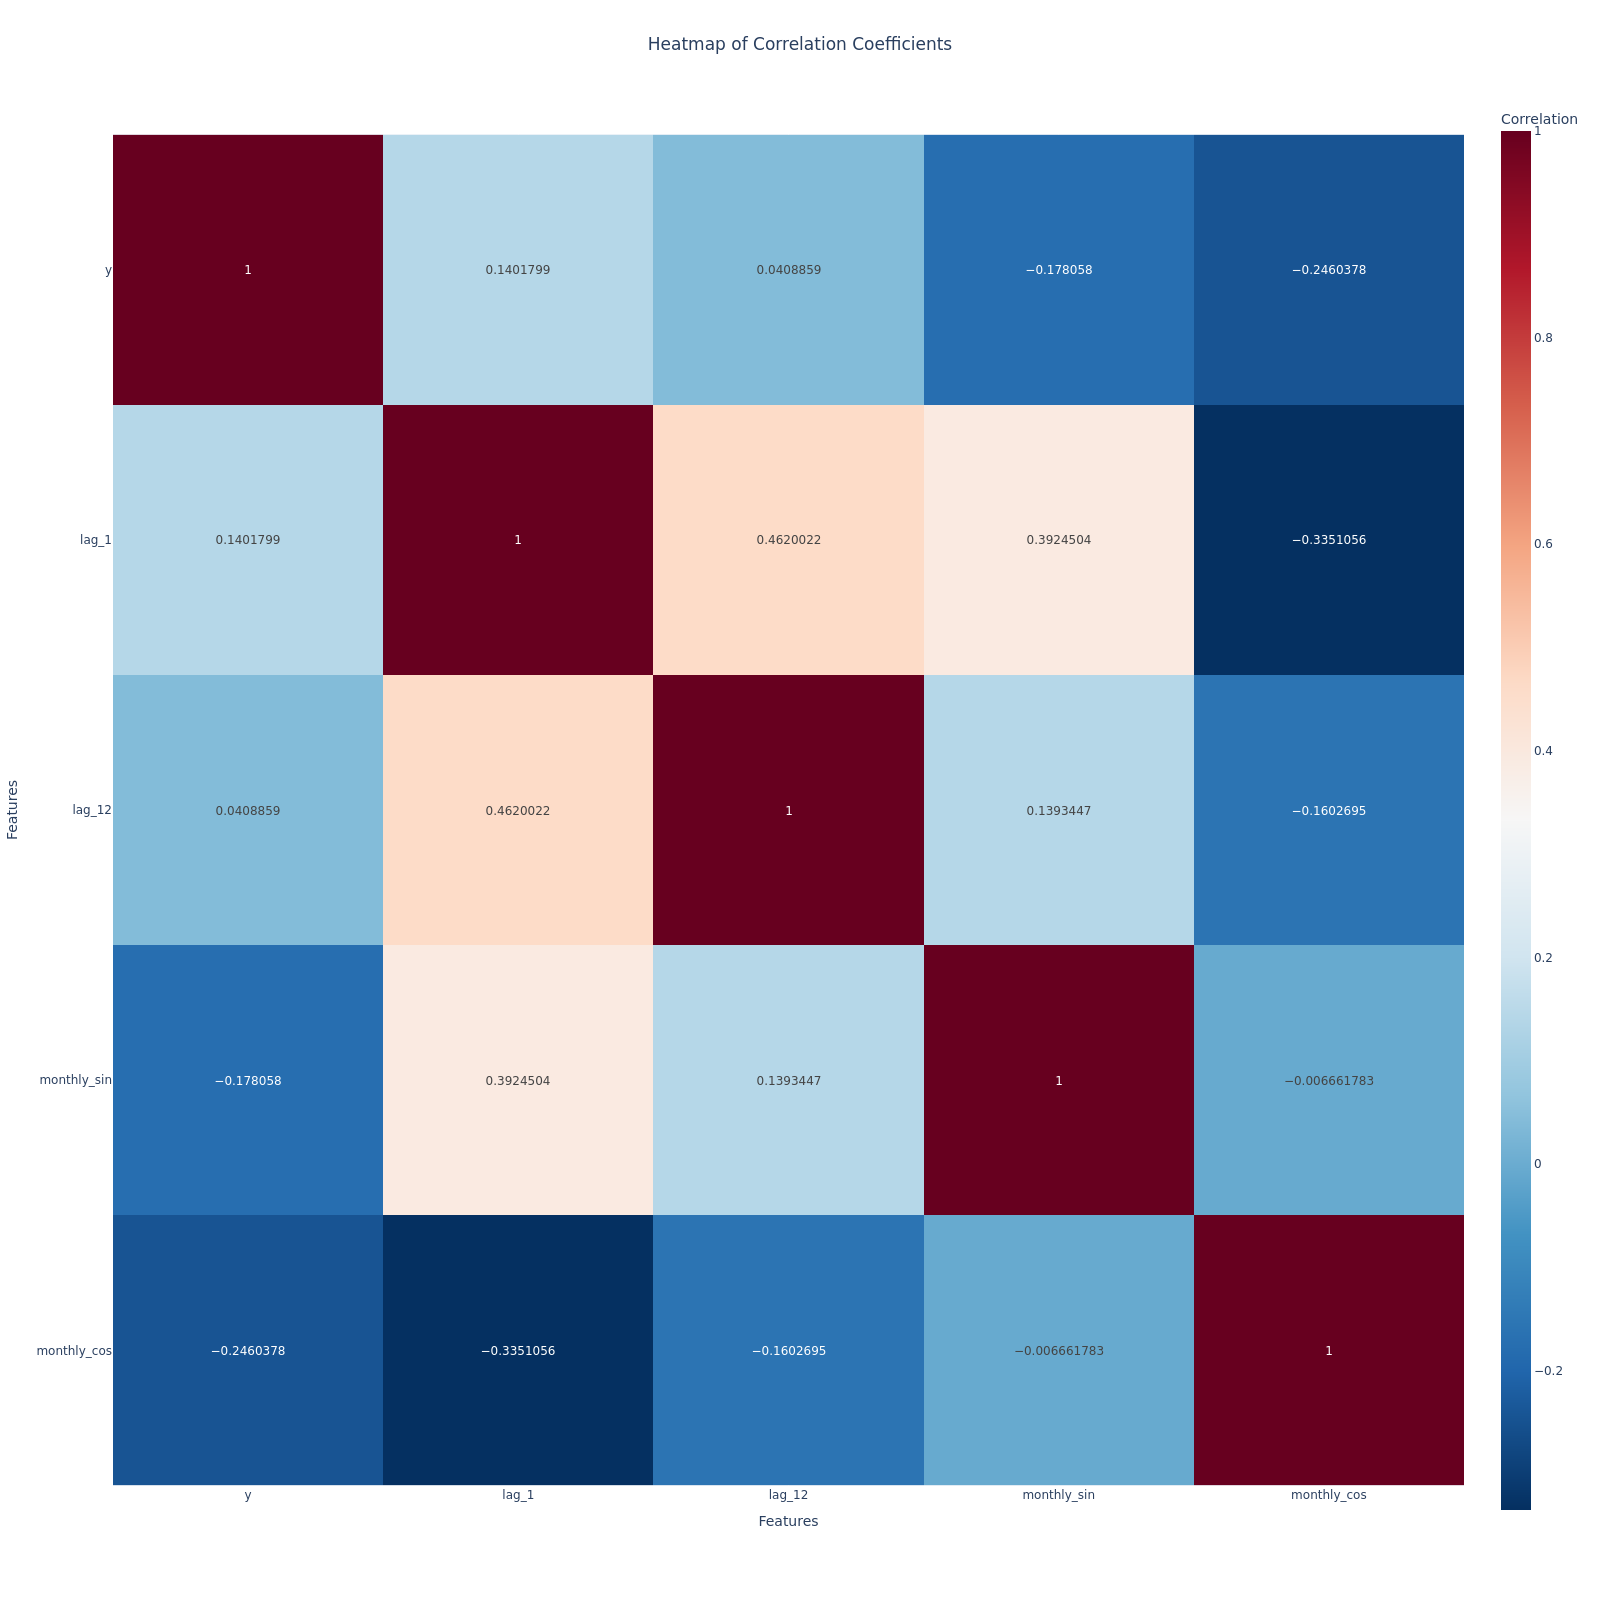

In [ ]:
corr_heatmap(df[df.columns[2:]], fig_type="png")

# Modelagem Estatística

In [ ]:
seasonal_length = 12
sf = StatsForecast(
    models=[
        AutoARIMA(season_length=seasonal_length),
        AutoETS(season_length=seasonal_length),
        AutoTheta(season_length=seasonal_length),
        AutoCES(season_length=seasonal_length),
    ],
    freq='MS',
    fallback_model=Naive(),
    n_jobs=-1
)

In [ ]:
horizon = 12
train = df[:-horizon]
test = df[-horizon:]

In [ ]:
def wape(actual, forecast):
    return np.sum(np.abs(actual - forecast)) / np.sum(np.abs(actual))

In [ ]:
fc = sf.forecast(df=train[["unique_id", "ds", "y"]], h=horizon) #fit_predict

In [ ]:
metrics = [
    mae,
    rmse,
    bias,
    cfe
]
models = ["AutoARIMA", "AutoETS", "AutoTheta", "CES", "Ensemble"]
scum = ["AutoARIMA", "AutoETS", "AutoTheta", "CES"]

In [ ]:
fc["Ensemble"] = fc[scum].median(axis=1)
fc.loc[fc["Ensemble"] < 1e-1, "Ensemble"] = 0

In [ ]:
test = pd.merge(test, fc, on=["unique_id", "ds"], how="inner")
columns = ["unique_id", 
               "ds", 
               "y", 
               "AutoARIMA", 
               "AutoETS", 
               "AutoTheta", 
               "CES", 
               "Ensemble"]

In [ ]:
bias(test[columns], models=models)

,unique_id,AutoARIMA,AutoETS,AutoTheta,CES,Ensemble
0,1,-3.5896,-12.34052,-6.921023,6.88073,-6.01693


In [ ]:
wape(test["y"], test["AutoARIMA"])

np.float64(0.031151835301726025)

In [ ]:
evaluate(test[columns], 
         metrics=metrics, 
         models=models, 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

,unique_id,metric,AutoARIMA,AutoETS,AutoTheta,CES,Ensemble
0,1,mae,14.833466,20.840342,17.010618,10.631396,15.197426
1,1,rmse,18.356624,24.882665,22.622863,15.016447,19.668917
2,1,bias,-3.589600,-12.340520,-6.921023,6.880730,-6.016930
3,1,cfe,-43.075195,-148.086243,-83.052277,82.568756,-72.203156
